In [12]:
import cv2
import sklearn.mixture
import matplotlib.pyplot as plt
import numpy as np
import igraph

In [13]:

def cutImage(event, x, y, flags, params):
    
    thickness = 2
    if event == cv2.EVENT_LBUTTONDOWN:
        start_pt = [x, y]
        crop = True
        
    elif event == cv2.EVENT_LBUTTONUP:
        end_pt = [x, y]
        crop = False
        
        cv2.rectangle(image, start_pt, end_pt, (255, 0, 0), thickness)
        cv2.imshow('image', image)


def GMMPrediction(image, mask, num_components = 5):
    '''
    Function to cluster images sections using gaussian mixture models
    
    Input:
        image - H x W x 3 - rgb image
        mask - H*W x 3 - logical vector mask
        num_components - scalar - number of gaussian components
    Returns:
        image_prediction - H x W - clustered image
        image_visualization - H x W - clustered image to visualize
        
    '''
    image_mask_vector = image.reshape((-1, 3))
    mask_vector = mask.reshape((-1,))
    image_mask_vector = image[mask, :]
    gmm_model = sklearn.mixture.GaussianMixture(n_components = num_components).fit(image_mask_vector)
    
    image_vector = image.reshape((-1, 3))
    labels = -gmm_model.score_samples(image_vector)
    
    image_prediction = labels.reshape((image.shape[0], image.shape[1]))
    image_visualization = image_prediction * 255
    
    return image_prediction, image_visualization


def add_neighbor_edges(image, edges, weights, row, column, mask, beta, gamma = 50):
    '''
    Function to weigh neighboring edges of a pixel
    Input:
    
    Returns:
    '''
    
    mask = mask*1
    height = image.shape[0]
    width = image.shape[1]
   
    # bottom pixel weight

    if (row + 1) < height:
        edges.append((row*width + column + 1, (row + 1)*width + column + 1))

        if mask[row + 1, column] == mask[row, column]:
            weights.append(0)
        else:
            weights.append(gamma*np.exp(-beta * np.sum(np.square(image[row + 1, column] - image[row, column]))))
    
    #right pixel
    if (column + 1) < width:
        edges.append((row*width + column + 1, (row)*width + column + 2))
        
        if mask[row, column + 1] == mask[row, column]:
            weights.append(0)
        else:
            weights.append(gamma*np.exp(-beta * np.sum(np.square(image[row, column + 1] - image[row, column]))))
    
    
    #     if (column + 1) < width and (row + 1) < height:
    #         edges.append(((row + 1)*width + column + 2, (row)*width + column + 1))

    #         if mask[row, column + 1] == mask[row, column]:
    #             weights.append(0)
    #         else:
    #             weights.append(gamma*np.exp(-beta * np.sum(np.square(image[row, column + 1] - image[row, column]))))
    
    return edges, weights


def calc_beta_value(image):
    '''
    Function to calculate beta value used in neighboring edge weight
    '''
    
    height = image.shape[0]
    width = image.shape[1]
    
    diff_up = np.sum(np.sum(np.square(image[1:height - 1, :] - image[:height - 2, :]), axis = 2))
    diff_side = np.sum(np.sum(np.square(image[:, 1:width - 1] - image[:, :width - 2]), axis = 2))
    diff_diag = np.sum(np.sum(np.square(image[1:height - 1, 1:width - 1] - image[:height - 2, :width - 2]), axis = 2))
    diff_lower_diag = np.sum(np.sum(np.square(image[:height - 2, 1:width - 1] - image[1:height - 1, :width - 2]), axis = 2))
    
    # 2 * (h - 1)(w - 1) + (h - 1)w + (w - 1)h = 4hw - 3h - 3w + 2
    beta = (1 / 2) * (2 * (height - 1) * (width - 1) + height * (width - 1) + (height - 1) * width ) * (1 / (diff_diag + diff_lower_diag + diff_up + diff_side))
    
    return beta

def update_mask(image, partition_source, bbox):
    '''
    Funtion to update the mask after every iteration
    '''
    x1 = int(bbox[0])
    x2 = int(bbox[2])
    y1 = int(bbox[1])
    y2 = int(bbox[3])
    
    mask = np.zeros((image.shape[0], image.shape[1]))
    
    image_selection = image[y1:y2, x1:x2]
    mask_selection = mask[y1:y2, x1:x2]
    print(mask_selection.shape)
    bbox_width = image_selection.shape[1]
    
    # removing source node from partition
    partition_source = np.array(partition_source, dtype = int)
    partition_source =  partition_source - 1
    mask_partition = partition_source >= 0
    partition_source = partition_source[mask_partition]
    
    fg_row = partition_source // bbox_width
    fg_col = partition_source % bbox_width
    
    
     
    mask_selection[fg_row, fg_col] = 1
    
    mask[y1:y2, x1:x2] = mask_selection
    
    return mask


def update_mask_image(image, partition_source, bbox):
    '''
    Funtion to update the mask after every iteration
    '''
    x1 = int(bbox[0])
    x2 = int(bbox[2])
    y1 = int(bbox[1])
    y2 = int(bbox[3])
    
    mask = np.zeros((image.shape[0], image.shape[1]))
    mask2 = mask.copy()
    mask2[y1:y2, x1:x2] = 1
    bbox_width = image.shape[1]
    
    # removing source node from partition
    partition_source = np.array(partition_source, dtype = int)
    partition_source =  partition_source - 1
    mask_partition = partition_source >= 0
    partition_source = partition_source[mask_partition]
    
    fg_row = partition_source // bbox_width
    fg_col = partition_source % bbox_width
    
    
     
    mask[fg_row, fg_col] = 1
    mask = mask * mask2
    return mask

def generate_image_graph(image, fg_gmm_prediction, bg_gmm_prediction, gamma = 50):
    '''
    Generates graph of the image
    
    Input:
        image - H x W x 3 - rgb image
        fg_gmm_prediction - H x W - matrix output obtained from foreground trained GMM containing log likelihood probabilities 
        bg_gmm_prediction - H x W - matrix output obtained from background trained GMM containing log likelihood probabilities
        gamma - scalar - gamma value for grabcut algorithm
    
    Returns:
        image_graph - igraph object - constructed graph with edges and and weights
    '''
    image_graph = igraph.Graph()
    
    beta = calc_beta_value(image)
    print(beta)
    # adding graph vertices=number of pixels + 2 (source and terminal)
    
    image_graph.add_vertices(image.shape[0] * image.shape[1] + 2)
    
    width = image.shape[1]
    height = image.shape[0]
    weights = []
    edges = []
    # node 0 is source, last node is terminal
    sink_node = int(image.shape[0]*image.shape[1] + 1)
    
    #K = 10
    # appending source and terminal weights
    
    for i in range(height):
        for j in range(width):
            
            edges.append((int(0), int(i*width + j + 1)))
            weights.append(bg_gmm_prediction[i,j])
            
            
            edges.append((sink_node, int(i*width + j + 1)))
            weights.append(fg_gmm_prediction[i,j])
            
            edges, weights = add_neighbor_edges(image, edges, weights, i, j, mask, beta, gamma)
    
    image_graph.add_edges(edges)
    image_graph.es['weight'] = weights
    
    return image_graph

In [17]:
if __name__ == "__main__":
    
    
    image_name = './data/images/person6.jpg'
    bbox_name = './data/bboxes/person6.txt'
    bbox = np.loadtxt(bbox_name, delimiter = ' ')
    print(bbox)
    image = cv2.imread(image_name)
    copy_image = image.copy()
    # cv2.namedWindow('image')
    # cv2.setMouseCallback('image', cutImage)

    # while True:

    #     cv2.imshow('image', image)
    #     key = cv2.waitKey(1) & 0xFF
    
    # cropped_image = 
        
    

[129. 112. 314. 532.]


(420, 185, 3)


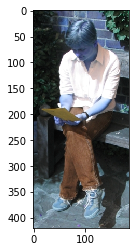

In [18]:
    cropped_image = image[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
    
    
#     print(mask.shape)
#     mask = (mask == 1)
    
    print(cropped_image.shape)
    plt.imshow(cropped_image, cmap = 'gray')

### GMM prediction

0.004288391203004298
(420, 185)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]
255


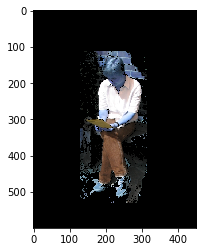

0.004288391203004298
(420, 185)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]
255


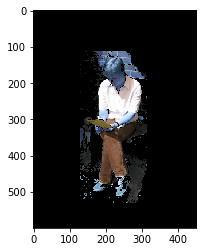

0.004288391203004298
(420, 185)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]
255


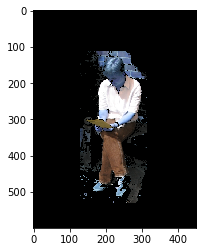

0.004288391203004298
(420, 185)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
255


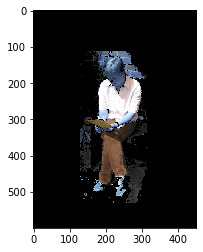

KeyboardInterrupt: 

In [19]:
    mask = np.zeros((image.shape[0], image.shape[1]))
    mask[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])] = 1
       
    x1 = int(bbox[0])
    x2 = int(bbox[2])
    y1 = int(bbox[1])
    y2 = int(bbox[3])
    gamma = 50
    lambda_value = 0.1
    for i in range(10):
        
        
        mask = mask == 1
        n_components = 5
        image_fg_gmm, image_visualization_fg = GMMPrediction(image, mask, n_components)
        image_bg_gmm, image_visualization_bg = GMMPrediction(image, ~mask, n_components)
        g_image = generate_image_graph(cropped_image, image_fg_gmm[y1:y2, x1:x2], image_bg_gmm[y1:y2, x1:x2], gamma)
        #g_image = generate_image_graph(image, image_fg_gmm, image_bg_gmm, gamma)
        
        partition_1, partition_2 = g_image.st_mincut(0, cropped_image.shape[0]*cropped_image.shape[1] + 1, g_image.es['weight'])
        #partition_1, partition_2 = g_image.st_mincut(0, image.shape[0]*image.shape[1] + 1, g_image.es['weight'])

        mask = update_mask(image, partition_1, bbox)
        print(mask[y1:y2,x1:x2])
        #mask = update_mask_image(image, partition_1, bbox)
        imageMasked = np.zeros(image.shape)
        mask = mask.astype(int)
        imageMasked[ :, :, 0] = image[ :, :, 0] * mask
        imageMasked[ :, :, 1] = image[ :, :, 1] * mask
        imageMasked[ :, :, 2] = image[ :, :, 2] * mask
        imageMasked = imageMasked.astype(int)
        print(np.max(image))
        #plt.figure()
        plt.imshow(imageMasked)
        plt.show()
